In [1]:
import cv2
import os
import random
import torch
from ultralytics import YOLO
import os
import shutil
import xml.etree.ElementTree as ET
# print("CUDA Available:", torch.cuda.is_available())  # Should return True
# print("CUDA Device Count:", torch.cuda.device_count())  # Should be >0
# print("GPU Name:", torch.cuda.get_device_name(0))  # Your GPU model

In [ ]:
def extract_frames(video_folder, output_train_folder, fps=10):
    """ 
    Extract frames from videos.
    - Training: All frames in a **single folder**, named sequentially (`frame_00000.jpg`, `frame_00001.jpg`, etc.).
    - Testing: Each video has its **own folder**, frames named sequentially (`frame_00000.jpg`, `frame_00001.jpg`, etc.).
    """
    os.makedirs(output_train_folder, exist_ok=True)

    videos = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    random.shuffle(videos)  # Shuffle videos for randomness
    # test_count = int(len(videos) * test_ratio)


    global_frame_count = 0  #Keep track of the total frame number for training

    def process_training(video_list, output_folder):
        nonlocal global_frame_count
        for video in video_list:
            video_path = os.path.join(video_folder, video)

            cap = cv2.VideoCapture(video_path)
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = max(1, int(frame_rate / fps))
            frame_count = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_count % frame_interval == 0:
                    frame_name = os.path.join(output_folder, f"frame_{global_frame_count:05d}.jpg")
                    cv2.imwrite(frame_name, frame)
                    global_frame_count += 1
                frame_count += 1

            cap.release()
            print(f"Training frames extracted from {video} into {output_folder}")

    # def process_testing(video_list, output_folder):
    #     for video in video_list:
    #         video_path = os.path.join(video_folder, video)
    #         video_name = os.path.splitext(video)[0]
    #         video_output_folder = os.path.join(output_folder, video_name)
    #         os.makedirs(video_output_folder, exist_ok=True)

    #         cap = cv2.VideoCapture(video_path)
    #         frame_rate = cap.get(cv2.CAP_PROP_FPS)
    #         frame_interval = max(1, int(frame_rate / fps))
    #         frame_count = 0
    #         saved_frame_count = 0

    #         while cap.isOpened():
    #             ret, frame = cap.read()
    #             if not ret:
    #                 break
    #             if frame_count % frame_interval == 0:
    #                 frame_name = os.path.join(video_output_folder, f"frame_{saved_frame_count:05d}.jpg")
    #                 cv2.imwrite(frame_name, frame)
    #                 saved_frame_count += 1
    #             frame_count += 1

    #         cap.release()
    #         print(f"Testing frames extracted from {video} into {video_output_folder}")

    # Process training videos (all frames go into a single folder with global numbering)
    process_training(videos, output_train_folder)


# extract_frames("../new-videos", "datasets/all-training", fps=10)

# # Extract frames for OPI videos (80% training, 20% testing)
# extract_frames("../opi-videos", "frames/opi-train", "frames/opi-test", fps=10)


Training frames extracted from Untitled video - Made with Clipchamp (6).mp4 into datasets/all-training
Training frames extracted from Untitled video - Made with Clipchamp (14).mp4 into datasets/all-training
Training frames extracted from Untitled video - Made with Clipchamp (26).mp4 into datasets/all-training
Training frames extracted from Untitled video - Made with Clipchamp (10).mp4 into datasets/all-training
Training frames extracted from check.mp4 into datasets/all-training
Training frames extracted from Untitled video - Made with Clipchamp (15).mp4 into datasets/all-training
Training frames extracted from 19.mp4 into datasets/all-training
Training frames extracted from 1.mp4 into datasets/all-training
Training frames extracted from Untitled video - Made with Clipchamp (34).mp4 into datasets/all-training
Training frames extracted from Untitled video - Made with Clipchamp (31).mp4 into datasets/all-training
Training frames extracted from 35.mp4 into datasets/all-training
Training fr

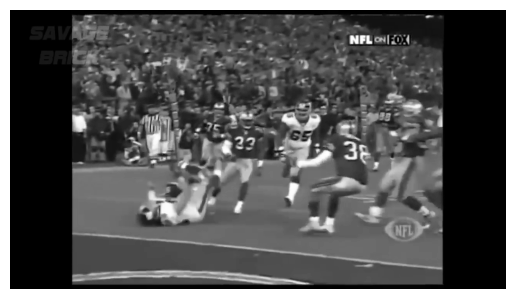

In [ ]:
# #Grey Scale Conversion, not necessarily used for now
# image_path = "frame_00022.jpg"  # Replace with your image path
# image = cv2.imread(image_path)

# if image is None:
#     print("Error: Image not found. Check the path!")
# else:
#     # Convert to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # Save the grayscale image
#     cv2.imwrite("output_bw.jpg", gray_image)

#     # Display using matplotlib (since cv2.imshow() doesn't work well in Jupyter)
#     import matplotlib.pyplot as plt
#     plt.imshow(gray_image, cmap='gray')
#     plt.axis('off')
#     plt.show()

In [ ]:
# Converting XML Values to .txt for YOLO Classification
# Define the directory containing the XML files
input_dir = "./"  # Change this to your directory if needed
output_dir = "./"  # Output is the same directory

# Class names (update this list based on your dataset)
classes = ["class1", "class2", "class3"]  # Replace with actual class names

# Function to convert XML to YOLO format
def convert_xml_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    yolo_labels = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in classes:
            continue  # Skip unknown classes
        
        class_id = classes.index(class_name)

        # Get bounding box details
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Convert to YOLO format
        x_center = ((xmin + xmax) / 2) / width
        y_center = ((ymin + ymax) / 2) / height
        w = (xmax - xmin) / width
        h = (ymax - ymin) / height

        # Append label in YOLO format
        yolo_labels.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    return yolo_labels

# Process all XML files in the directory
for file in os.listdir(input_dir):
    if file.endswith(".xml"):
        xml_path = os.path.join(input_dir, file)
        txt_filename = file.replace(".xml", ".txt")
        txt_path = os.path.join(output_dir, txt_filename)

        # Convert XML to YOLO format
        yolo_labels = convert_xml_to_yolo(xml_path)

        # Write to a TXT file
        with open(txt_path, "w") as txt_file:
            txt_file.write("\n".join(yolo_labels))

print("Conversion complete. YOLO label files saved.")

In [22]:
#Assigning manual labelling equivalence with the images

images_dir = "datasets/all-training"
labels_dir = "datasets/label-training-v1"  
output_dir = "datasets/manual-training" 


os.makedirs(output_dir, exist_ok=True)

# Copy only images that have corresponding labels
copied_count = 0
for label_file in os.listdir(labels_dir):
    if label_file.endswith(".txt"):
        image_file = label_file.replace(".txt", ".jpg")  # Adjust if images have a different extension
        image_path = os.path.join(images_dir, image_file)
        if os.path.exists(image_path):  # Ensure image exists
            shutil.copy(image_path, os.path.join(output_dir, image_file))  # Copy file
            copied_count += 1

print(f"✅ Copied {copied_count} labeled frames to {output_dir}.")


✅ Copied 170 labeled frames to datasets/manual-training.


In [26]:
from ultralytics import YOLO

# Load trained model
model = YOLO("datasets/manual-training/runs/detect/train/weights/best.pt")

# Path to the test image
image_path = "detected_frame_00047.jpg"

# Run inference
results = model(image_path, device="cuda", save=False)

# Check if any objects were detected
if not results[0].boxes or len(results[0].boxes) == 0:
    print("❌ No objects detected!")
else:
    print("✅ Detected Objects:")
    for box in results[0].boxes:
        class_id = int(box.cls[0].item())  # Convert tensor to int
        class_name = model.names[class_id]  # Get class name
        conf = box.conf[0].item()  # Convert confidence score to float
        print(f" - {class_name} ({conf:.2f} confidence)")



image 1/1 e:\Hacklytics-2025\hacklytics-2025\detected_frame_00047.jpg: 384x640 1 interference, 17.4ms
Speed: 1.9ms preprocess, 17.4ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
✅ Detected Objects:
 - interference (0.57 confidence)


In [27]:
# Load trained YOLO model (from Step 2)
model = YOLO("datasets/manual-training/runs/detect/train/weights/best.pt")

# Directory with unlabeled frames
frames_dir = "datasets/all-training"
output_labels_dir = "datasets/label-training-final"

# Ensure output directory exists
os.makedirs(output_labels_dir, exist_ok=True)

# Iterate through all images in the unlabeled folder
image_files = [f for f in os.listdir(frames_dir) if f.endswith((".jpg", ".png"))]

for image_file in image_files:
    image_path = os.path.join(frames_dir, image_file)
    results = model(image_path, device="cuda", save=False)

    # Generate YOLO label file
    label_file = os.path.join(output_labels_dir, image_file.replace(".jpg", ".txt").replace(".png", ".txt"))

    with open(label_file, "w") as f:
        for box in results[0].boxes:
            class_id = int(box.cls[0])  # Class ID
            x_center, y_center, width, height = box.xywhn[0]  # YOLO normalized format
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

    print(f"✅ Auto-labeled {image_file} -> {label_file}")

print("\n🔥 Auto-labeling completed! Review generated labels before training.")



image 1/1 e:\Hacklytics-2025\hacklytics-2025\datasets\all-training\frame_00026.jpg: 384x640 1 interference, 38.4ms
Speed: 2.3ms preprocess, 38.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
✅ Auto-labeled frame_00026.jpg -> datasets/label-training-final\frame_00026.txt

image 1/1 e:\Hacklytics-2025\hacklytics-2025\datasets\all-training\frame_00027.jpg: 384x640 1 interference, 35.9ms
Speed: 2.0ms preprocess, 35.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
✅ Auto-labeled frame_00027.jpg -> datasets/label-training-final\frame_00027.txt

image 1/1 e:\Hacklytics-2025\hacklytics-2025\datasets\all-training\frame_00028.jpg: 384x640 1 interference, 25.5ms
Speed: 1.9ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
✅ Auto-labeled frame_00028.jpg -> datasets/label-training-final\frame_00028.txt

image 1/1 e:\Hacklytics-2025\hacklytics-2025\datasets\all-training\frame_00029.jpg: 384x640 1 interference, 25.5ms
Speed